### Loading and preparing the data

In [145]:
import mysql.connector  # or import pymysql
import pandas as pd

#Database connection parameters
db_config = {
    "host": "192.168.1.164",  # Specify your host
    "user": "#######",           # Specify your username
    "password": "#######",  # Specify your password
    "database": "raw_data"      # Specify your database name
}

#Connecting to MySQL database
connection = mysql.connector.connect(**db_config)  # or pymysql.connect(**db_config)

#SQL query to retrieve data
query = "SELECT * FROM raw_data.dpi_sessions;"  # Name of your table

#Reading data into a DataFrame
df = pd.read_sql(query, connection)

#Closing the connection
connection.close()

#Displaying the first 5 rows of the DataFrame
print(df.head())


C:\Users\erkin\AppData\Local\Temp\ipykernel_9856\797297092.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


   session_id          start_time            end_time  base_station_id  \
0           1 2025-01-16 12:29:35 2025-02-28 18:10:25              685   
1           2 2025-01-18 00:50:23 2026-01-16 19:05:35               78   
2           3 2025-01-19 03:10:01 2025-09-03 03:54:11              818   
3           4 2025-01-12 00:18:47 2025-01-13 06:33:41              539   
4           5 2025-01-05 00:11:36 2025-04-17 22:42:00              732   

    latitude   longitude          user_ip   destination_ip          domain  \
0  28.815873  -78.978584    47.172.78.228    70.143.71.233     walmart.com   
1  44.665145 -109.830670   200.175.62.248  203.169.212.190  applestore.com   
2  31.200968  -83.236699  171.152.252.114   136.218.109.97     walmart.com   
3  30.049574  -80.008818   197.13.181.219  194.108.246.245  shop.apple.com   
4  34.101854 -114.795900   192.189.138.88    2.205.250.139  applestore.com   

  protocol  ...  browser                                         user_agent  \
0    HT

### Preprocessing the data

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   session_id         100000 non-null  int64         
 1   start_time         100000 non-null  datetime64[ns]
 2   end_time           100000 non-null  datetime64[ns]
 3   base_station_id    100000 non-null  int64         
 4   latitude           100000 non-null  float64       
 5   longitude          100000 non-null  float64       
 6   user_ip            100000 non-null  object        
 7   destination_ip     100000 non-null  object        
 8   domain             100000 non-null  object        
 9   protocol           100000 non-null  object        
 10  port               100000 non-null  int64         
 11  traffic_volume     100000 non-null  int64         
 12  traffic_direction  100000 non-null  object        
 13  packet_count       100000 non-null  int64    

In [150]:
#Checking for missing values
missing_data = df.isnull().sum()

In [152]:
missing_data

session_id               0
start_time               0
end_time                 0
base_station_id          0
latitude                 0
longitude                0
user_ip                  0
destination_ip           0
domain                   0
protocol                 0
port                     0
traffic_volume           0
traffic_direction        0
packet_count             0
avg_packet_size          0
duration                 0
country                  0
region                   0
city                     0
asn                      0
isp                      0
user_id                  0
subscriber_id            0
msisdn                   0
device_type              0
os                       0
browser                  0
user_agent               0
application_name         0
content_type             0
risk_category            0
category                 0
is_vpn                   0
connection_type          0
throttled                0
error_code           25000
dtype: int64

#### It is better to use drop when the data is really not needed, but just dropping it won't help, 
if there are nan or empty values ​​in some columns, it is best to replace them with values

In [155]:
#df_clean = df.dropna()

#### error_code           25000

In [158]:
#Replacing missing values in the 'error_code' column with 'No Error'
df['error_code'] = df['error_code'].fillna('No Error')

#Checking if the missing values have been replaced
missing_data = df.isnull().sum()
print(missing_data)

session_id           0
start_time           0
end_time             0
base_station_id      0
latitude             0
longitude            0
user_ip              0
destination_ip       0
domain               0
protocol             0
port                 0
traffic_volume       0
traffic_direction    0
packet_count         0
avg_packet_size      0
duration             0
country              0
region               0
city                 0
asn                  0
isp                  0
user_id              0
subscriber_id        0
msisdn               0
device_type          0
os                   0
browser              0
user_agent           0
application_name     0
content_type         0
risk_category        0
category             0
is_vpn               0
connection_type      0
throttled            0
error_code           0
dtype: int64


### it is important to filter out duplicate data, if there are duplicates they can affect further analytics and also a question for data engineers so that they take them into account too

In [161]:
#Checking for duplicates
duplicates = df[df.duplicated(keep=False)]  # Keep=False means we keep all duplicates for inspection

#If duplicates exist, log them and remove
if not duplicates.empty:
    #Print the number of duplicates
    print(f"Found {duplicates.shape[0]} duplicate rows.")
    
    #Save duplicates to a separate DataFrame
    duplicates_df = duplicates.copy()  # Storing the duplicates in a new DataFrame
    
    #Removing duplicates directly in the original DataFrame
    df.drop_duplicates(inplace=True)
    
    #Show the number of rows after removing duplicates
    print(f"Number of rows after removing duplicates: {df.shape[0]}")
else:
    print("No duplicates found.")


No duplicates found.


#### if suddenly there are duplicates, then you can immediately farm them in a separate data enginner (Below is just an example so you can understand my experience in the SMTP library) (or you can write down the engineers' data in the database/table so that they can set up their own scheduler for monitoring)

In [164]:
#Let's imagine that the data has been cleared
df_clean = df

In [168]:
#Converting columns to appropriate data types
df_clean['start_time'] = pd.to_datetime(df_clean['start_time'])
df_clean['end_time'] = pd.to_datetime(df_clean['end_time'])

### Preliminary analysis (summary and unique values)

In [171]:
#Unique values for categorical columns
unique_values = {
    "category": df_clean['category'].nunique(),
    "risk_category": df_clean['risk_category'].nunique(),
    "connection_type": df_clean['connection_type'].nunique(),
    "device_type": df_clean['device_type'].nunique(),
    "country": df_clean['country'].nunique(),
    "region": df_clean['region'].nunique(),
    "protocol": df_clean['protocol'].nunique(),
    "application_name": df_clean['application_name'].nunique(),
    "traffic_direction": df_clean['traffic_direction'].nunique(),
}


In [173]:
#Displaying the unique values count for each column
unique_values

{'category': 7,
 'risk_category': 3,
 'connection_type': 3,
 'device_type': 3,
 'country': 1,
 'region': 50,
 'protocol': 4,
 'application_name': 3,
 'traffic_direction': 2}

In [175]:
#Checking the distribution of categories in the key variables
category_dist = df_clean['category'].value_counts()
risk_category_dist = df_clean['risk_category'].value_counts()

In [177]:
#Displaying the distribution of categories
category_dist, risk_category_dist

(category
 electronics     14406
 gaming          14339
 technical       14324
 streaming       14304
 social media    14255
 furniture       14202
 building        14170
 Name: count, dtype: int64,
 risk_category
 suspicious    33416
 safe          33297
 malicious     33287
 Name: count, dtype: int64)

### Time and geographic analysis

In [180]:
#Time analysis: sessions per day
df_clean['date'] = df_clean['start_time'].dt.date
sessions_per_day = df_clean.groupby('date').size()

In [186]:
sessions_per_day.head(5)

date
2025-01-01    5240
2025-01-02    5278
2025-01-03    5293
2025-01-04    5348
2025-01-05    5383
dtype: int64

In [188]:
#Geographic analysis: sessions per region
region_dist = df_clean['region'].value_counts()
region_dist.head()

region
Pennsylvania    2096
Maine           2090
Wyoming         2084
Nebraska        2080
New York        2070
Name: count, dtype: int64

In [190]:
#Geographic analysis: sessions per country
country_dist = df_clean['country'].value_counts()
country_dist.head()

country
United States    100000
Name: count, dtype: int64

In [192]:
#Displaying the first few rows of time and geographic analysis
sessions_per_day, region_dist, country_dist

(date
 2025-01-01    5240
 2025-01-02    5278
 2025-01-03    5293
 2025-01-04    5348
 2025-01-05    5383
 2025-01-06    5361
 2025-01-07    5498
 2025-01-08    5486
 2025-01-09    5346
 2025-01-10    5376
 2025-01-11    5340
 2025-01-12    5263
 2025-01-13    5293
 2025-01-14    5387
 2025-01-15    5388
 2025-01-16    5285
 2025-01-17    5377
 2025-01-18    5511
 2025-01-19    3547
 dtype: int64,
 region
 Pennsylvania      2096
 Maine             2090
 Wyoming           2084
 Nebraska          2080
 New York          2070
 Massachusetts     2069
 Delaware          2055
 New Jersey        2045
 Kansas            2043
 Tennessee         2042
 Oregon            2040
 Kentucky          2039
 Utah              2037
 Arkansas          2037
 Ohio              2034
 West Virginia     2034
 Missouri          2031
 Texas             2019
 Washington        2012
 Arizona           2010
 Mississippi       2007
 Idaho             2004
 Wisconsin         2001
 Oklahoma          1999
 Indiana       

### Checking for anomalies in the data

##### look for anomalies in key variables such as traffic_volume, packet_count, and duration. Identify values that are unusually high or low.

In [196]:
#Traffic volume anomalies
traffic_anomalies = df_clean[df_clean['traffic_volume'] > df_clean['traffic_volume'].quantile(0.95)]
#Duration anomalies
duration_anomalies = df_clean[df_clean['duration'] > df_clean['duration'].quantile(0.95)]

#### Identify anomalous sessions that may be needed for further analysis, such as unusual traffic patterns or session durations. This data can be used for further investigations or building security models.

In [199]:
#Displaying anomaly data
traffic_anomalies[['session_id', 'traffic_volume', 'start_time', 'duration']], duration_anomalies[['session_id', 'duration', 'start_time']]

(       session_id  traffic_volume          start_time  duration
 25             26         9772185 2025-01-03 08:37:06   7878581
 52             53         9870432 2025-01-14 09:36:34  10791608
 76             77         9570407 2025-01-18 18:45:41  14081225
 96             97         9797299 2025-01-12 15:35:36  15530614
 123           124         9693792 2025-01-01 14:30:44   6002169
 ...           ...             ...                 ...       ...
 99818       99819         9845629 2025-01-10 21:59:16  17544229
 99904       99905         9505576 2025-01-03 23:43:34  31576061
 99928       99929         9532791 2025-01-07 21:19:02  27975869
 99963       99964         9527337 2025-01-04 05:35:15   4693333
 99998       99999         9987924 2025-01-04 08:15:54  29147584
 
 [5000 rows x 4 columns],
        session_id  duration          start_time
 1               2  31428912 2025-01-18 00:50:23
 46             47  31175412 2025-01-14 08:36:12
 50             51  31454272 2025-01-05 13:47

### Data visualization (using seaborn and matplotlib)

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

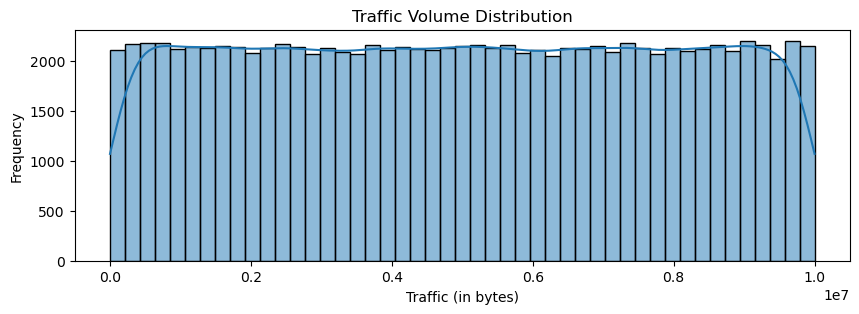

In [217]:
#Traffic volume distribution
plt.figure(figsize=(10, 3))
sns.histplot(df_clean['traffic_volume'], kde=True)
plt.title('Traffic Volume Distribution')
plt.xlabel('Traffic (in bytes)')
plt.ylabel('Frequency')
plt.show()

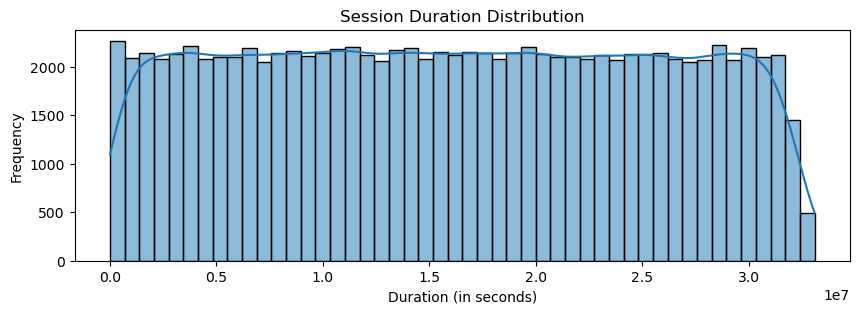

In [215]:
#Session duration distribution
plt.figure(figsize=(10, 3))
sns.histplot(df_clean['duration'], kde=True)
plt.title('Session Duration Distribution')
plt.xlabel('Duration (in seconds)')
plt.ylabel('Frequency')
plt.show()

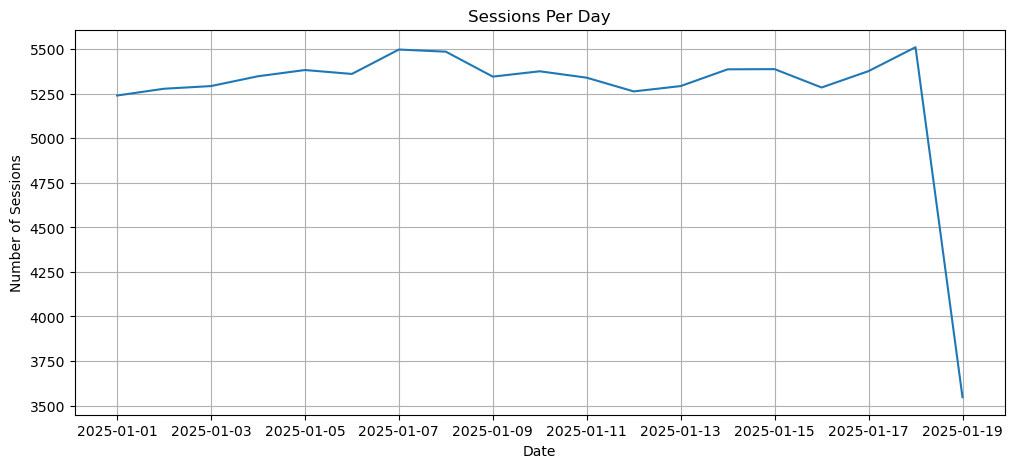

In [208]:
#Sessions per day
plt.figure(figsize=(12, 5))
sessions_per_day.plot(kind='line')
plt.title('Sessions Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.grid(True)
plt.show()

### when data was generated by regions, you won't see any special analytics by sessions, since there can't be such things in a real company

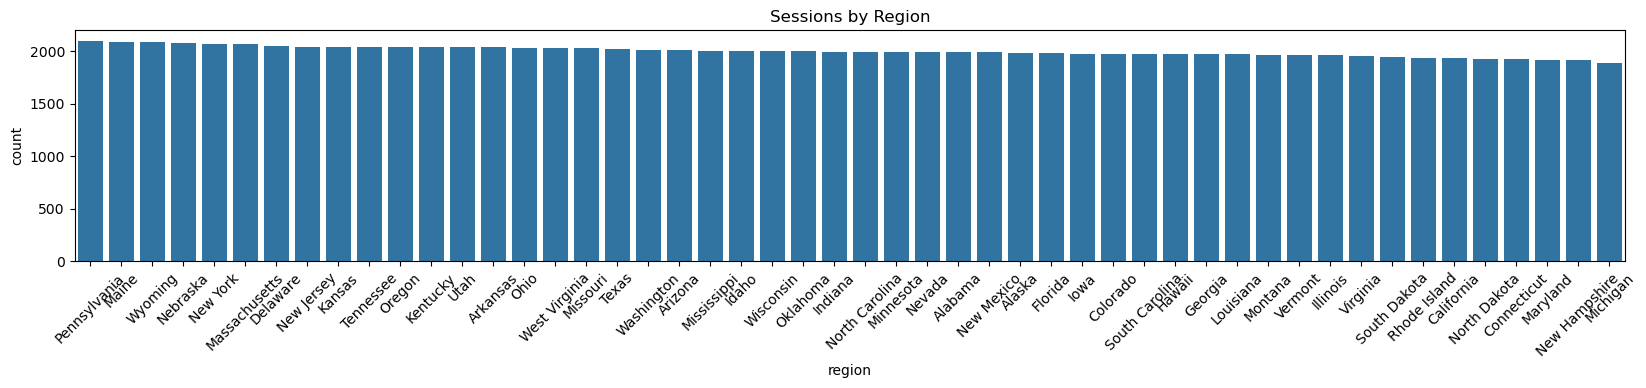

In [213]:
#Sessions by region
plt.figure(figsize=(20, 3))
sns.countplot(data=df_clean, x='region', order=df_clean['region'].value_counts().index)
plt.title('Sessions by Region')
plt.xticks(rotation=45)
plt.show()

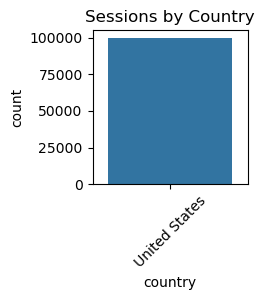

In [223]:
#Sessions by country
plt.figure(figsize=(2, 2))
sns.countplot(data=df_clean, x='country', order=df_clean['country'].value_counts().index)
plt.title('Sessions by Country')
plt.xticks(rotation=45)
plt.show()

### Very Simple Key metrics

In [226]:
#DAU (Daily Active Users)
dau = df_clean.groupby('date')['user_id'].nunique()

In [228]:
#MAU (Monthly Active Users)
df_clean['month'] = df_clean['start_time'].dt.to_period('M')
mau = df_clean.groupby('month')['user_id'].nunique()

In [234]:
#Displaying the first values of DAU and MAU
dau.head(), mau.head()

(date
 2025-01-01    5227
 2025-01-02    5263
 2025-01-03    5283
 2025-01-04    5333
 2025-01-05    5373
 Name: user_id, dtype: int64,
 month
 2025-01    95116
 Freq: M, Name: user_id, dtype: int64)